In [169]:
import os 
import calendar
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt, butter, filtfilt
from scipy.fftpack import fft, fftfreq, ifft
from dataset import Dataset, ActivityType, SAMPLE_RATE, Sensor
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import f1_score

### something notes:
https://datascience.stackexchange.com/questions/41601/input-shape-for-simpler-time-series-in-lstmcnn

## 1.Load the dataset from original source 

In [170]:
# !wget -c --timeout 10 https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip -O dataset.zip
# !unzip -d dataset -q dataset.zip
# !echo "Done!"

In [171]:
!ls dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/

id00b70b13.csv id3e3e50c7.csv id82b9735c.csv idb221f542.csv idf540d82b.csv
id079c763c.csv id4ea159a8.csv id86237981.csv idbae5a811.csv idf5e3678b.csv
id1165e00c.csv id5308a7d6.csv id8af5374b.csv idc735fc09.csv idfc5f05e4.csv
id1c7e64ad.csv id5993bf4a.csv id8e66893c.csv idc91a49d0.csv idff99de96.csv
id1f372081.csv id650857ca.csv id9603e9c3.csv idd80ac2b4.csv
id34e056c8.csv id687ab496.csv ida61e8ddf.csv idecc9265e.csv
id37a54bbf.csv id7c20ee7a.csv idabd0c53c.csv idf1ce9a0f.csv


In [172]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## 2. Read dataset, start explortory data analysis
- Using Dataset Class initialize an object and have an overview of the whole dataframe. 
- Visualize different activity types by bar chart.
- Choosing one of the activity and plot it to see if there's any insight from it.We might find some certain frequency patterns of it.


In [173]:
dset = Dataset("./dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data")
dset._df
sample_df=pd.read_csv('dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/id00b70b13.csv')
sample_df

,activity,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_x,la_y,la_z,ra_x,ra_y,ra_z
0,99,0.01,0.039,1.020,-0.020,-0.180,1.234,0.023,0.156,0.855,-0.582,0.887,0.449,0.074
1,99,0.02,-0.629,-0.461,0.973,-0.246,0.137,0.969,-0.707,0.559,0.449,-0.027,0.141,0.934
2,99,0.03,-0.926,-1.262,0.691,0.238,-0.328,1.219,-1.445,1.367,0.367,-0.164,0.660,1.344
3,99,0.04,-0.871,-1.496,-0.246,0.711,-0.484,0.414,-1.660,1.645,-0.543,-0.141,1.027,0.707
4,99,0.05,-0.727,-1.621,-0.559,1.031,-0.297,0.145,-1.762,1.676,-0.918,-0.121,1.230,0.438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303295,99,3032.96,0.172,-0.930,-0.320,0.000,0.000,0.000,0.160,0.020,0.977,-0.070,0.000,0.969
303296,99,3032.97,0.172,-0.930,-0.320,0.000,0.000,0.000,0.156,0.020,0.980,-0.070,0.000,0.969
303297,99,3032.98,0.172,-0.930,-0.320,0.000,0.000,0.000,0.156,0.020,0.977,-0.070,0.000,0.969
303298,99,3032.99,0.172,-0.930,-0.320,0.000,0.000,0.000,0.156,0.020,0.980,-0.070,0.000,0.969


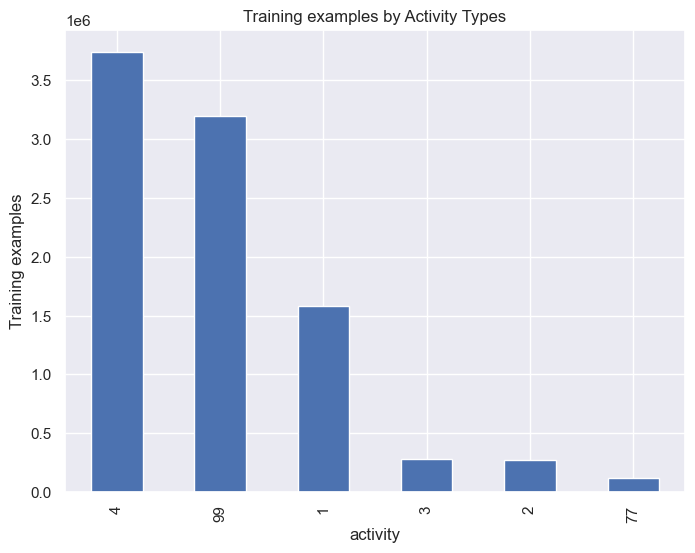

In [174]:
plt.xlabel('Activity Type')
plt.ylabel('Training examples')
dset._df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

In [175]:
activity_name = ActivityType(1).name
activity_name

'WALKING'

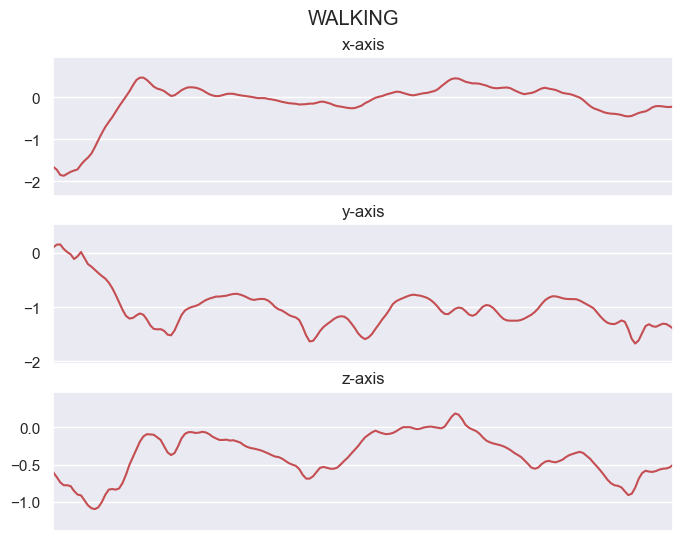

In [176]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in dset._df['activity'].unique():
    if activity == 99 or activity == 77 or activity ==4:
        continue
    limit = dset._df[dset._df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True)
    axis_plot(ax0, limit['timestamp'], limit['lw_x'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['lw_y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['lw_z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(ActivityType(activity).name)
    plt.subplots_adjust(top=0.9)
    plt.show()
    break
    

In [177]:
# separate each activity based on the numebr
def separate_activity(df,activity):
    if activity == 99:
        df_non_study = df[df['activity'] == 99]
        return df_non_study
    elif activity == 77:
        df_clapping = df[df['activity'] == 77]
        return df_clapping
    elif activity ==4:
        df_driving = df[df['activity'] == 4]
        return df_driving
    elif activity ==3:
        df_ascending_stairs = df[df['activity'] == 3]
        return df_ascending_stairs
    elif activity ==2:
        df_descending_stairs = df[df['activity'] == 2]
        return df_descending_stairs
    elif activity ==1:
        df_walking = df[df['activity'] == 1]
        return df_walking

In [178]:
def make_x_y_z_plot(df):
    # colors = ["#F7F3E3","#7F7CAF","#78C0E0"]
    option_colors = sns.color_palette()
    colors =[option_colors[0],option_colors[1],option_colors[2]]
    # create larger subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
        # Plotting
    for i, (ax, variables) in enumerate(zip(axs.flat, [('lw_x', 'lw_y', 'lw_z'), ('lh_x', 'lh_y', 'lh_z'), ('la_x', 'la_y', 'la_z'), ('ra_x', 'ra_y', 'ra_z')])):
        for variable, color in zip(variables, colors):
            sns.lineplot(data=df, x='time_s', y=variable, ax=ax, linewidth=0.5, color=color, label=variable)
        
        ax.legend(loc='upper right', fontsize=12)
        ax.set_title(' vs time_s '.join(variables), fontsize=16)
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.set_ylabel('Value', fontsize=14)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

#### This is one example from all the datasets, and the activity is walking, and lw,lh,la,ra each stands for left wrist, left hip, left ankle,and right ankel.from above we can see that there is no significant difference between them, since they're from the same activity.
- Plotting for Walking

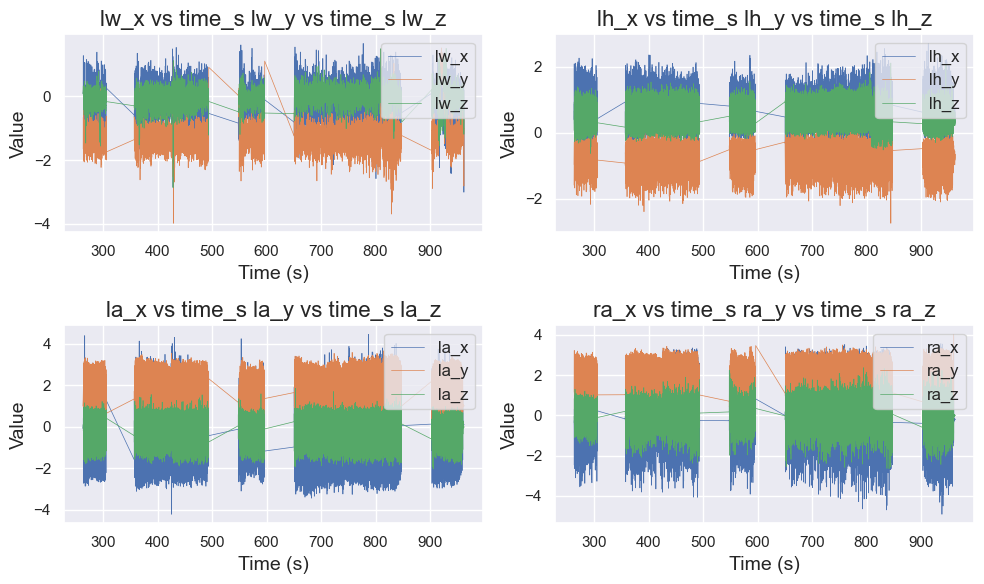

In [179]:
df = separate_activity(sample_df,1)
make_x_y_z_plot(df)

- Plotting for Descending stairs

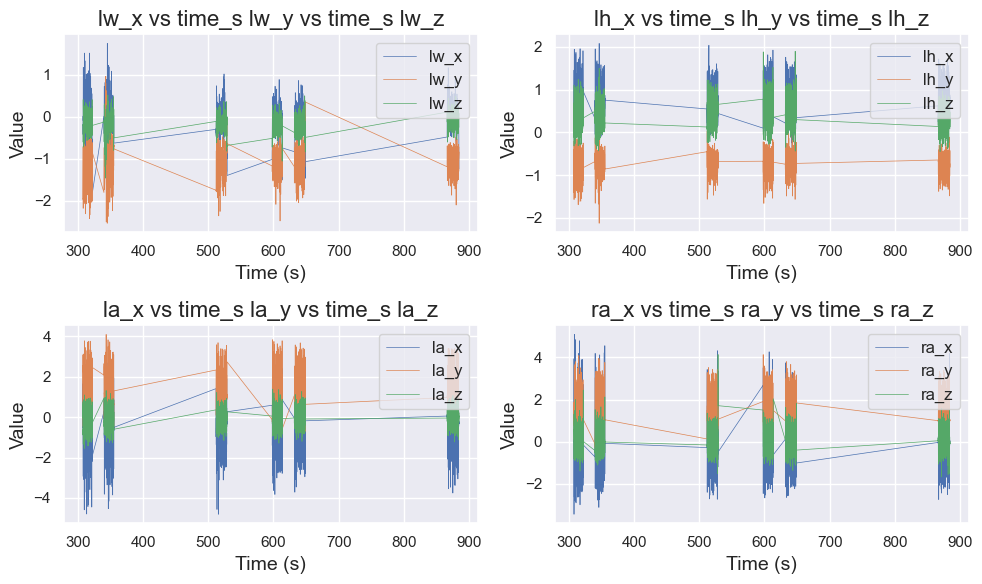

In [180]:
df = separate_activity(sample_df,2)
make_x_y_z_plot(df)

- Plotting for Ascending stairs

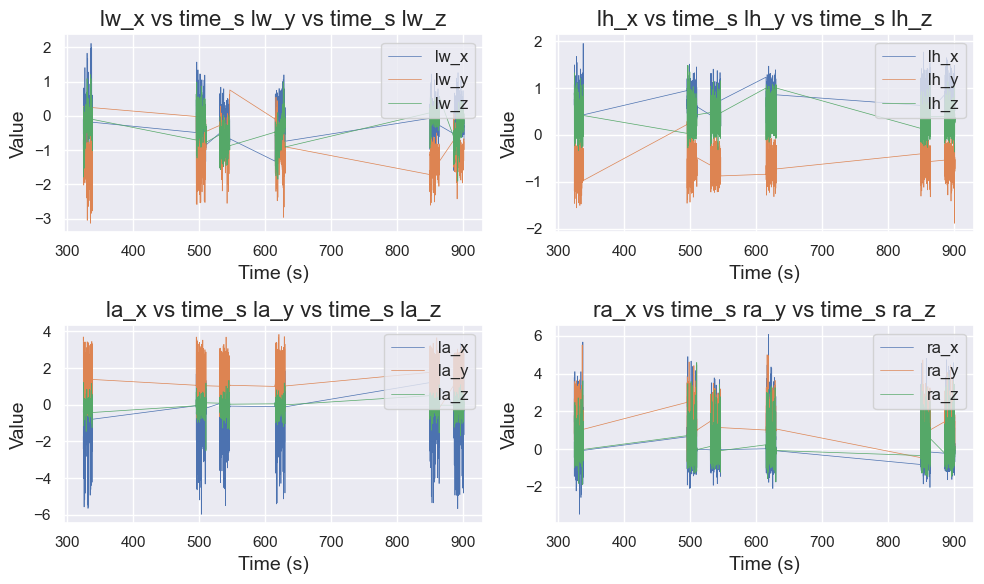

In [181]:
df = separate_activity(sample_df,3)
make_x_y_z_plot(df)

### 3.Transforming by using vector magnitude

- After the initial plotting, we may have a rough idea how the plotting looks like, but there are too many vairables, it creates some trouble when doing analysis, I refer to this paper:[Differentiating Between Walking and Stair Climbing Using Raw Accelerometry Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7453603/pdf/nihms-1529153.pdf), the suggested idea is to consolidate the multimensional, the x,y,z into a single measure, which is the vector magnitude, this can help reduce the amount of variables, also can remove the effects of sensor orientation(caused by users swinging their arms.)


- The formula of vector magnitude can be described as:

    $vm = \sqrt{x^2 + y^2 + z^2}$ <br>

- This formula consolidates the three axes data into a single measure by taking the Euclidean distance in the 3D space.


In [182]:
def calculate_vector_magnitude(df):
    df_transformed = df.copy()
    columns_to_calculate_VM = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    for i in range(0,len(columns_to_calculate_VM),3):
        x_col = columns_to_calculate_VM[i]
        y_col = columns_to_calculate_VM[i+1]
        z_col = columns_to_calculate_VM[i+2]
        magnitude_col = f"magnitude_{i//3}"
        # Calculate vector magnitude while removing sensor orientation
        df_transformed[magnitude_col] = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)
    # print(df_transformed.columns)
    return df_transformed


### 4.Data processing
- **Apply noise filtering**
<p>Real-world data always contains noises, so here I applies a low-pass filter to remove the high-frequency noise, making the data smoother and easier to analyse.</p>

- **Data standardization** 
<p>By standardizing, I tranform the data to have a mean of zero and a std of one. This ensures all the features have the same scale, which is vital for many ml algorithms.</p>

- **Data segmentation**
<p>By choosing the window size of 5.12(size of window in seconds), and overlapping percentage as 50%, I break the data into smaller windows, this can help reduce the amount of data I need to deal with, and also can help in capturing the temporal nature of activities and making the patterns more recognizble for classification.</p>
    

In [183]:
def butter_lowpass(cutoff, fs, order=3):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(df, columns, cutoff, fs, order=3):
    df_filtered = df.copy()
    for column in columns:
        b, a = butter_lowpass(cutoff, fs, order=order)
        df_filtered[column] = filtfilt(b, a, df[column].values)
    return df_filtered
    
def apply_noise_filter(df):
    # Assuming you want to apply a median filter and low-pass Butterworth filter
    columns_to_apply_filter = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z",'magnitude_0','magnitude_1', 'magnitude_2', 'magnitude_3']
    # columns_to_apply_filter = ['magnitude_0','magnitude_1', 'magnitude_2', 'magnitude_3']

    # Apply median filter to the specified columns
    df_filtered = df.copy()
    for column in columns_to_apply_filter:
        df_filtered[column] = medfilt(df[column], kernel_size=5)  # Adjust kernel size as needed

    # Apply low-pass Butterworth filter to the filtered data
    cutoff_freq = 0.2  # Corner frequency in Hz
    order = 3  # Butterworth filter order
    fs = 100  # Sample rate (assuming equally spaced samples)
    df_filtered = butter_lowpass_filter(df_filtered, columns_to_apply_filter, cutoff_freq, fs, order)

    return df_filtered
    
def standardize(df):
    # initialize standard scaler
    scaler = StandardScaler()
    # select the columns to standardize
    columns_to_standardize = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z",'magnitude_0','magnitude_1', 'magnitude_2', 'magnitude_3']
    
    # columns_to_standardize = ['magnitude_0','magnitude_1', 'magnitude_2', 'magnitude_3']

    # standardize the columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    # Convert the 'time_s' column to a datetime format if it isn't already
    df['time_s'] = pd.to_datetime(df['time_s'], unit='s') 
    # Set the 'time_s' column as the index of the DataFrame
    df.set_index('time_s', inplace=True)
        # check if the data has been standardized
    # print(df[columns_to_standardize].mean())  # should be close to 0
    # print(df[columns_to_standardize].std())   # should be close to 1

    # Reset the index back to RangeIndex
    df.reset_index(inplace=True)
    # Convert 'time_s' back to its original unit
    df['time_s'] = df['time_s'].astype(int)

    return df

In [184]:
# standardize and segmentation
def data_processed(df):
    
    df_new = standardize(df)
    
    df_filtered = apply_noise_filter(df_new)

    # window_size = 3  # Size of each window in seconds
    window_size = [5.12,10.24]
    overlap = 0.5  # Overlap percentage (50%)
    sampling_rate = 100  # Sampling rate of your data (samples per second)
    #(i.e. 2.56s × 100Hz *0.5 =  128 sample ref: paper1

    # Calculate the number of data points in each window
    window_length = int(window_size[0] * sampling_rate)

    # Calculate the number of data points to shift the window by for the given overlap
    shift_length = int(window_length * overlap)

    # Initialize an empty list to store the segmented data
    segmented_data = []

    # Iterate over the data using a sliding window
    start_index = 0
    while start_index + window_length <= len(df_filtered):
        end_index = start_index + window_length
        segment = df_filtered.iloc[start_index:end_index]
        segmented_data.append(segment)
        start_index += shift_length

    # Concatenate the segmented data into a new DataFrame
    df_segmented = pd.concat(segmented_data)

    # Reset the index of the segmented DataFrame
    df_segmented.reset_index(drop=True, inplace=True)


    return df_segmented


### 5.Extract data insights
- mean
- variance
- maximum
- Minimum

In [185]:
def statistical_extraction(data_processed,activity_name):
    results = []
    # calculate mean,std,variance,minimum,maximun,
    mean = np.mean(data_processed)
     # Calculate standard deviation
    std = np.std(data_processed)

    # Calculate variance
    variance = np.var(data_processed)

    # Calculate minimum
    minimum = np.min(data_processed)

    # Calculate maximum
    maximum = np.max(data_processed)
    result = {
            'activity': f'{activity_name}',
            'mean': mean,
            'std': std,
            'variance': variance,
            'minimum': minimum,
            'maximum': maximum
        }
        
    results.append(result)


    return results


In [186]:
from scipy.fftpack import fft, ifft

variables = {
    'magnitude_0': 'lw',
    'magnitude_1': 'lh',
    'magnitude_2': 'la',
    'magnitude_3': 'ra'
}

### 6.Using FFT to visualize the frequency change
- FFT can break down a time-based signal into its constituent frequencies. This is useful as different activities might have distinct frequency components.


In [187]:
def FFT_plot(fft_results, labels):
    N = len(fft_results[0])
    sampling_rate = 100  # Assuming a sampling rate of 100 Hz
    frequencies = np.fft.fftfreq(N, d=1/sampling_rate)
    
    # Plot the FFT results
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_theme(context='notebook', style='darkgrid', palette="deep")
    
    for fft_result, label in zip(fft_results, labels):
        ax.plot(frequencies, fft_result, label=label)
    
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
    ax.set_title('FFT Results')
    ax.legend()
    ax.grid(True)
    plt.show()
def FFT_DWT(VM, variables):
    fft_results = []
    labels = []
    for key, label in variables.items():
        X = fft(VM[key].values)
        fft_result = np.abs(X)
        print(f'FFT result for {label}:', fft_result)
        fft_results.append(fft_result)
        labels.append(label)


In [188]:
activity_dict = {   
        "non-study activity" : 99,
        "clapping" : 77,
        "driving" : 4,
        "ascending stairs" : 3,
        "descending stairs" : 2,
        "walking": 1
    }

In [189]:
def plot_all(df):
    sns.set_theme(context='notebook', style='darkgrid', palette="deep")
    # variables = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]

    variables = {
    'magnitude_0': 'lw',
    'magnitude_1': 'lh',
    'magnitude_2': 'la',
    'magnitude_3': 'ra'
}
   
    # df.plot(x='time_s', y=variables)
    df.plot(x='time_s', y=list(variables.keys()))
    # tick_positions = range(0, 3034, 100) 
    # plt.xticks(tick_positions)
    # Adding labels and a legend
    
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend([variables[var] for var in variables.keys()])
    
    # Displaying the plot
    plt.show()

In [190]:
def method_can_do_all(sample_df,activity):

    # 1.read and plot
    df = sample_df
    df_activity = separate_activity(df,activity)
    df_activity_tranform = calculate_vector_magnitude(df_activity)
    # print(df_activity_tranform)
    

    # 2.standardize and downsampling and segmentation
    df_activity_processed = data_processed(df_activity_tranform)
   
    # 3. Noise filtering
    filtered_data = apply_noise_filter(df_activity_processed)
    
    # 4.statical analysis
    results = statistical_extraction(filtered_data,activity)

    plot_all(filtered_data)
   

    return results
    

Now activity is ascending stairs and the code is 3


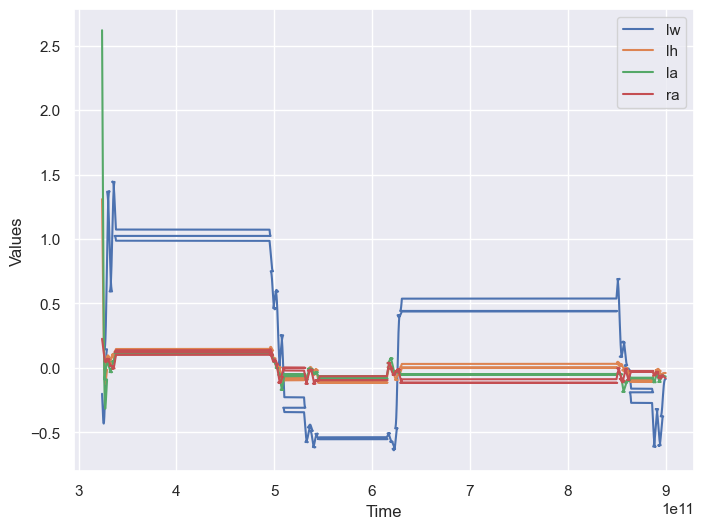

Now activity is descending stairs and the code is 2


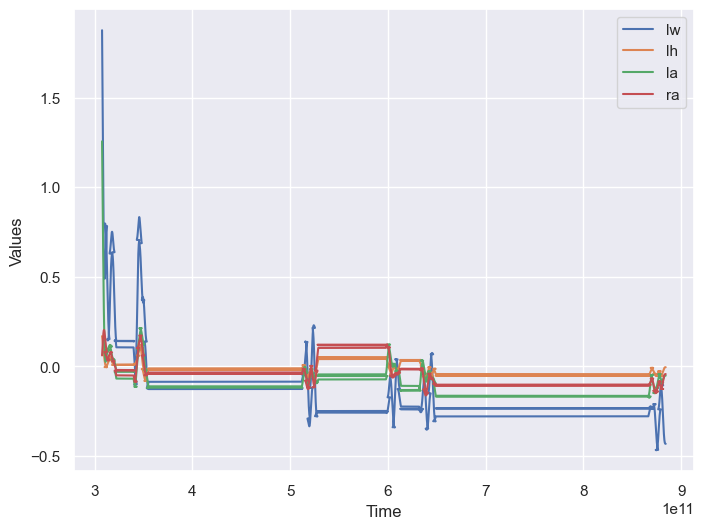

Now activity is walking and the code is 1


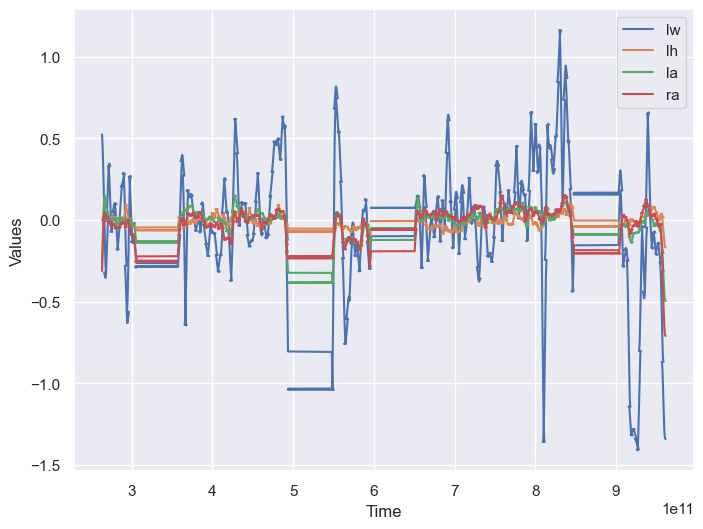

[[{'activity': '3',
   'mean': 34591438610.76074,
   'std': time_s         1.908827e+11
   activity       0.000000e+00
   lw_x           3.793273e-01
   lw_y           6.535134e-01
   lw_z           7.201317e-01
   lh_x           1.699251e-01
   lh_y           1.132155e-01
   lh_z           2.406100e-01
   la_x           1.166807e-01
   la_y           1.948391e-01
   la_z           7.661332e-02
   ra_x           1.070123e-01
   ra_y           4.515769e-02
   ra_z           7.906194e-02
   magnitude_0    5.708740e-01
   magnitude_1    1.024543e-01
   magnitude_2    1.774102e-01
   magnitude_3    6.437800e-02
   dtype: float64,
   'variance': time_s         3.643622e+22
   activity       0.000000e+00
   lw_x           1.438892e-01
   lw_y           4.270797e-01
   lw_z           5.185896e-01
   lh_x           2.887453e-02
   lh_y           1.281776e-02
   lh_z           5.789319e-02
   la_x           1.361439e-02
   la_y           3.796229e-02
   la_z           5.869600e-03
   ra_x      

In [191]:
results = []
for activity in activity_dict:
    if activity == "walking" or activity == "descending stairs" or activity =="ascending stairs":
        print(f"Now activity is {activity} and the code is {activity_dict[activity]}")    
        activity_results = method_can_do_all(sample_df,activity_dict[activity])
        results.append(activity_results)

results

In [192]:
# if __name__ == "__main__":
#     main()

### 7. Prepare dataset for splitting

In [193]:
def get_magnitude(data, normalize=True):
    
    """
    Calculate vector magnitude from XYZ axes.
    inputs:
        data: A numpy array with shape (n x 3), n is number of samples and
        there are 3 axes X, Y, Z respectively.
        
        normalize: If true, perform normalization on resulting vector magnitude
        
    output:
        vector magnitude with shape: (n x 1), n is number if samples
    """
    data = np.sum(data ** 2, axis=1)
    if normalize:
        data = (data - data.mean()) / data.std()
    return data

def low_pass(x, cutoff):
    """
    Pass input signal x through a lowpass filter with a certain cutoff frequency.
    All frequency components higher than cutoff frequency will be damped to zero.
    """
    p = fft(x)
    f = fftfreq(x.shape[0], SAMPLE_RATE)
    p[f >= cutoff] = 0
    p[f < 0] = 0
    y = ifft(p)
    y = np.real(y)
    y = y / y.std()
    return y
    

raw_feats = []
gt = []
for t in np.arange(0, 100*5, 5):
    x = dset.get(ActivityType.WALKING, Sensor.RIGHT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    raw_feats.append(x)
    gt.append(ActivityType.WALKING.value)
    
    x = dset.get(ActivityType.DESCENDING, Sensor.RIGHT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    
    raw_feats.append(x)
   
   
    gt.append(ActivityType.DESCENDING.value)
    
    x = dset.get(ActivityType.ASCENDING, Sensor.RIGHT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    
    raw_feats.append(x)
   
    gt.append(ActivityType.ASCENDING.value)

# print(raw_feats[0:10])

raw_feats = np.array(raw_feats)
gt = np.array(gt)



print(f"Features shape: {raw_feats.shape}")
#(N, 500) N rows 500 columns.  each feature has N samples. like the first 1-3 rows is made up by 1. walking - 500 samples in different times.
print(f"Ground truth shape: {gt.shape}")

Features shape: (300, 500)
Ground truth shape: (300,)


In [194]:
raw_feats #each row represent one activity - one position(hip/ankel or..) - five hundreds records in a certain time period.

array([[ 5.83564022e-01, -1.23472957e-01, -6.40200907e-01, ...,
         2.56554210e+00,  2.05712875e+00,  1.35784443e+00],
       [ 2.55922680e-01,  5.28604389e-01,  7.95379149e-01, ...,
         4.07264359e-02,  6.07211778e-04,  6.61680709e-02],
       [-7.21544994e-01, -7.63850823e-01, -8.23194331e-01, ...,
        -8.70717320e-01, -7.90253819e-01, -7.30795286e-01],
       ...,
       [ 9.73201668e-01,  1.18235418e+00,  1.18018278e+00, ...,
         1.42622906e-01,  3.08823165e-01,  6.35262755e-01],
       [ 1.22432825e+00,  1.32763211e+00,  1.41391187e+00, ...,
         7.18229266e-01,  9.27213224e-01,  1.09426807e+00],
       [-5.23566649e-02,  5.79580436e-02,  1.95801949e-01, ...,
        -3.58377381e-01, -2.49281887e-01, -1.49334095e-01]])

In [195]:
# Combine feature shape and ground truth shape together preparing for train test split
data = np.concatenate((raw_feats,gt.reshape(-1,1)), axis=1)
data.shape

(300, 501)

In [196]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

y = gt
X = raw_feats

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 8. Apply random forest classifying

In [197]:
from sklearn.model_selection import GridSearchCV
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

print("\n***************************************************************")
print("*****Random Forest With Default Hyperparameters Train/Test*****")
print("***************************************************************\n")


# ************ Train/Test *********************
# Create Random Forest Classifier using default hyperparameters

default_rf_clf = RandomForestClassifier(random_state=0)
default_rf_clf.fit(X_train, y_train)
default_train_test_preds = default_rf_clf.predict(X_test)

# Create confusion matrix
print("\n*****Default Hyperparameters Test Confusion Matrix*****")
confusion_matrix = pd.crosstab(y_test, default_train_test_preds, rownames=['Actual Activity'], colnames=['Predicted Activity'])
print(confusion_matrix)

# print(confusion_matrix[1][1])
# Print accuracy
accuracy = (((confusion_matrix[1][1] + confusion_matrix[2][2] + confusion_matrix[3][3] )) / (X_test.shape[0]) * 100)
print("\nDefault Hyperparameters Test Accuracy = {0:0.4f}%".format(accuracy))



***************************************************************
*****Random Forest With Default Hyperparameters Train/Test*****
***************************************************************


*****Default Hyperparameters Test Confusion Matrix*****
Predicted Activity   1   2   3
Actual Activity               
1                   21   0   1
2                    0  17   2
3                    1   1  17

Default Hyperparameters Test Accuracy = 91.6667%


In [198]:
#0.65 for lw ,  0.81 for LEFT_ANKLE, 0.86 for ra , 0.76 for LEFT_HIP

In [199]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from pprint import pprint

In [200]:
# ************ Random Forest Classifier using grid search for hyper-parameters ******************
print("\n\n***************************************************************")
print("*****************Random Forest Grid Search*********************")
print("***************************************************************\n")

# Number of trees in random forest
# Using num=2 will significantly reduce run time (~3 min vs ~65 min)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 2)]
# Using num=10 will significantly increase run time
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# Using num=2 will significantly reduce run time (~3 min vs ~65 min)
max_depth = [int(x) for x in np.linspace(10, 110, num = 2)]
# Using num=10 will significantly increase run time
#max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print("The values that will be used for the grid search are:")
pprint(grid)

print("\n*****Performing the Grid Search of the Hyperparameters*****")
# Create a regressor using values from grid
rfc = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = grid, cv = 3, n_jobs = -1, verbose = 1)

# Train the classifier
best_grid = grid_search.fit(X_train, y_train)

# Make predictions
grid_preds = best_grid.predict(X_test)



***************************************************************
*****************Random Forest Grid Search*********************
***************************************************************

The values that will be used for the grid search are:
{'bootstrap': [True, False],
 'max_depth': [10, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 2000]}

*****Performing the Grid Search of the Hyperparameters*****
Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/menglutao/.pyenv/versions/3.8.10/envs/HDA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/menglutao/.pyenv/versions/3.8.10/envs/HDA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/menglutao/.pyenv/versions/3.8.10/envs/HDA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

In [201]:
print("The best hyperparameters found during the grid search are:")
print(best_grid.best_params_)

The best hyperparameters found during the grid search are:
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 2000}


In [202]:


print("\n************************************************************************")
print("*****Random Forest With Hyperparameters from Grid Search Train/Test*****")
print("************************************************************************\n")
# Train the Classifier with new values from grid search
rf_clf = RandomForestClassifier(max_depth = best_grid.best_params_["max_depth"], 
	min_samples_split = best_grid.best_params_["min_samples_split"], 
	min_samples_leaf = best_grid.best_params_["min_samples_leaf"], 
	bootstrap = best_grid.best_params_["bootstrap"], 
	max_features = best_grid.best_params_["max_features"], 
	n_estimators = best_grid.best_params_["n_estimators"], n_jobs=-1, random_state=0)
rf_clf.fit(X_train, y_train)
train_test_preds = rf_clf.predict(X_test)



y_score = rf_clf.fit(X_train, y_train).predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_test_bin.shape[1]

# Create confusion matrix
print("\n*****Grid Search Hyperparameters Test Confusion Matrix*****")
confusion_matrix = pd.crosstab(y_test, train_test_preds, rownames=['Actual Income'], colnames=['Predicted Income'])
print(confusion_matrix)

# Print accuracy
grid_search_accuracy = (((confusion_matrix[1][1] + confusion_matrix[2][2] + confusion_matrix[3][3] )) / (X_test.shape[0]) * 100)

print("\nGrid Search Hyperparameters Test Accuracy = {0:0.4f}%".format(grid_search_accuracy))



************************************************************************
*****Random Forest With Hyperparameters from Grid Search Train/Test*****
************************************************************************


*****Grid Search Hyperparameters Test Confusion Matrix*****
Predicted Income   1   2   3
Actual Income               
1                 22   0   0
2                  0  17   2
3                  0   2  17

Grid Search Hyperparameters Test Accuracy = 93.3333%


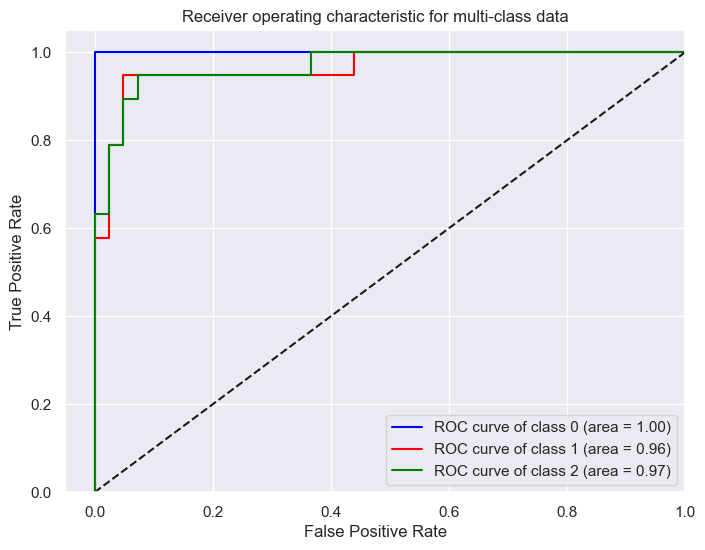

In [203]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [204]:
default_accuracy = accuracy
print("\nCompared to the random forest classifier created with default hyperparameters, the accuracy of the " +
	"classifier created with optimal hyperparameters determined by grid search is " +
	"{0:0.4f}% better".format((grid_search_accuracy - default_accuracy)))


Compared to the random forest classifier created with default hyperparameters, the accuracy of the classifier created with optimal hyperparameters determined by grid search is 1.6667% better


In [205]:
f1 = f1_score(y_test, train_test_preds, average=None)
print(f"F1 Score: {f1}")

F1 Score: [1.         0.89473684 0.89473684]


##### TODO : Classification report of human activities for the KNN algorithm.

In [206]:
from IPython.display import display, Image
# display(Image(filename='report-RandomForest.jpg'))

#### TODO : KNN


[0.65833333 0.59166667 0.62083333 0.60833333 0.57916667 0.59583333
 0.57083333 0.53333333 0.55833333 0.54583333 0.54583333 0.55
 0.54583333 0.5125     0.51666667 0.52916667 0.5125     0.50416667
 0.52083333]


Text(0, 0.5, 'Cross-Validated Accuracy')

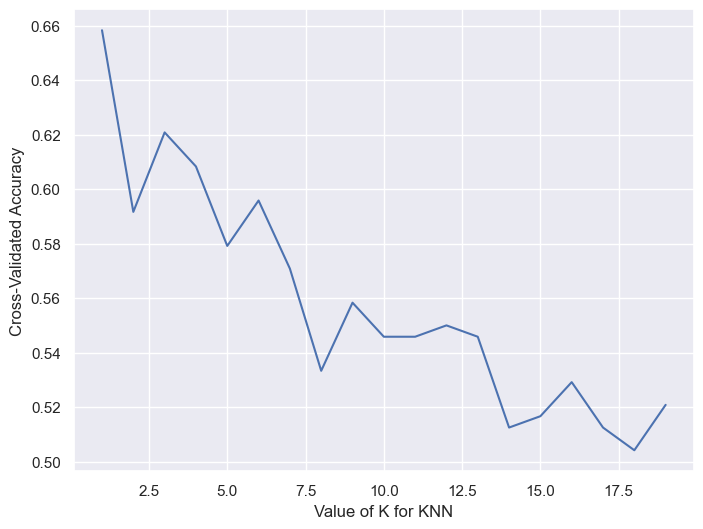

In [223]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.feature_selection import SelectKBest,chi2
from tslearn.metrics import dtw


k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier() #10 / 20
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train,y_train)

grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

##### Using chi-square for feature selection

The $$ \chi^2 $$ (chi-squared) test is a non-parametric statistical test used to determine the association or independence between two categorical variables.


[0.44583333 0.41666667 0.3875     0.44166667 0.44166667 0.39583333
 0.425      0.4        0.425      0.45416667 0.44583333 0.4375
 0.425      0.42916667 0.4375     0.40416667 0.39583333 0.4125
 0.4       ]


Text(0, 0.5, 'Cross-Validated Accuracy')

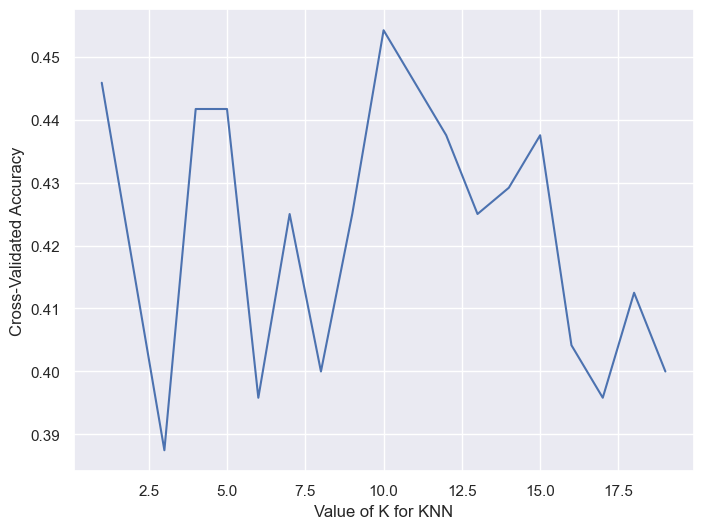

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Use chi2 to select the top 2 features
X_new = SelectKBest(chi2, k=2).fit_transform(X_train, y_train)
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier(metric=dtw) #10 / 20
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_new,y_train)

grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

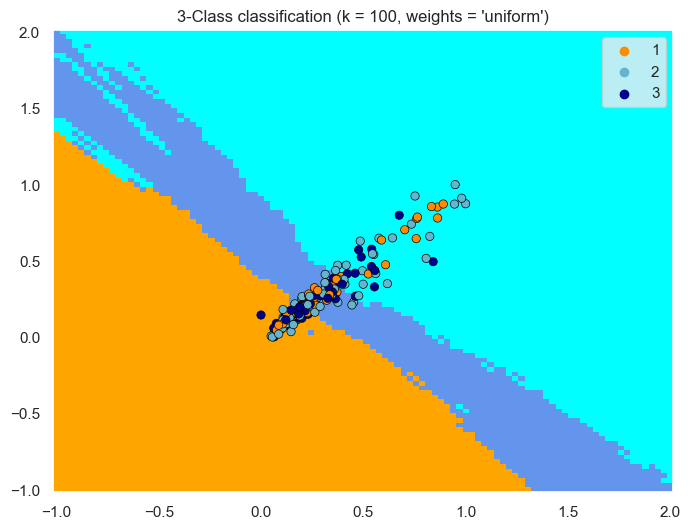

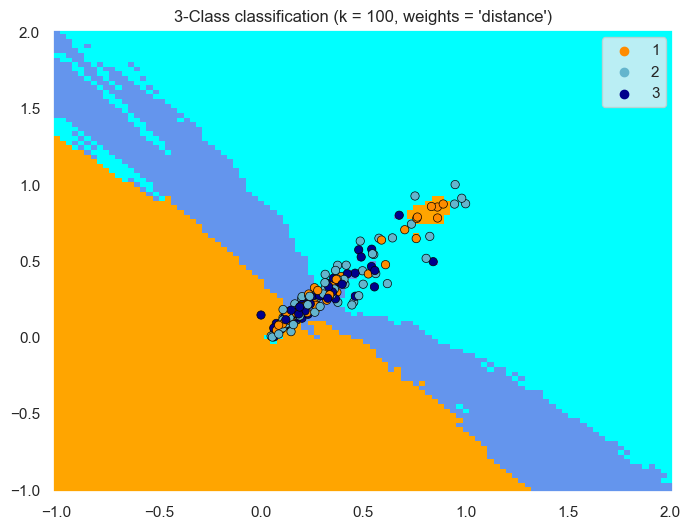

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn import datasets, neighbors
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = 100

# X = X_train[:,4:6] #iris.data[:, :2]
X = X_new
y = y_train 

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        # xlabel=iris.feature_names[0],
        # ylabel=iris.feature_names[1],
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=y,
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )

plt.show()

#### Todo: LSTM + CNN
- Need to use colab to run this part or figure out a way to use tensorflow 1 or migrate the code to tensorflow 2

In [211]:
# # import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
# import tensorflow as tf #Tensorflow 2.x
# from keras.src.layers import RNN


In [212]:
# training_data_count = len(X_train)  # 240 training series (with 50% overlap between each serie)
# test_data_count = len(X_test)  # 60 testing series
# n_steps = len(X_train[0])  # 500 timesteps per series
# n_input = 1  # 1 input parameters per timestep 

# # LSTM Neural Network's internal structure

# n_hidden = 32 # Hidden layer num of features
# n_classes = 3 # Total classes (should go up, or should go down)

# # Training

# learning_rate = 0.0025
# lambda_loss_amount = 0.0015
# training_iters = training_data_count * 300  # Loop 300 times on the dataset
# batch_size = 50
# display_iter = 30000  # To show test set accuracy during training

# # Some debugging info

# print("Some useful info to get an insight on dataset's shape and normalisation:")
# print("(X shape, y shape, every X's mean, every X's standard deviation)")
# print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
# print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

In [213]:
# def LSTM_RNN(_X, _weights, _biases):
#     # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters.
#     # Moreover, two LSTM cells are stacked which adds deepness to the neural network.
#     # Note, some code of this notebook is inspired from an slightly different
#     # RNN architecture used on another dataset, some of the credits goes to
#     # "aymericdamien" under the MIT license.

#     # (NOTE: This step could be greatly optimised by shaping the dataset once
#     # input shape: (batch_size, n_steps, n_input)
#     _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
#     # Reshape to prepare input to hidden activation
#     _X = tf.reshape(_X, [-1, n_input])
#     # new shape: (n_steps*batch_size, n_input)

#     # ReLU activation, thanks to Yu Zhao for adding this improvement here:
#     _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
#     # Split data because rnn cell needs a list of inputs for the RNN inner loop
#     _X = tf.split(_X, n_steps, 0)
#     # new shape: n_steps * (batch_size, n_hidden)

#     # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
#     lstm_cell_1 = tf2.compat.v1.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True,initializer= tf2.initializers.GlorotUniform())
#     lstm_cell_2 = tf2.compat.v1.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True,initializer= tf2.initializers.GlorotUniform())
#     lstm_cells = tf2.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)

#     # lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     # lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
#     # Get LSTM cell output

#     outputs, states = tf.keras.layers.RNN(lstm_cells, _X, dtype=tf.float32)

#     # Get last time step's output feature for a "many-to-one" style classifier,
#     # as in the image describing RNNs at the top of this page
#     lstm_last_output = outputs[-1]

#     # Linear activation
#     return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


# def extract_batch_size(_train, step, batch_size):
#     # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.

#     shape = list(_train.shape)
#     shape[0] = batch_size
#     batch_s = np.empty(shape)

#     for i in range(batch_size):
#         # Loop index
#         index = ((step-1)*batch_size + i) % len(_train)
#         batch_s[i] = _train[index]

#     return batch_s


# def one_hot(y_, n_classes=n_classes):
#     # Function to encode neural one-hot output labels from number indexes
#     # e.g.:
#     # one_hot(y_=[[5], [0], [3]], n_classes=6):
#     #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]

#     y_ = y_.reshape(len(y_))
#     return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


In [214]:

# # tf.disable_v2_behavior() 

# # Graph input/output
# x = tf1.placeholder(tf.float32, [None, n_steps, n_input])
# y = tf1.placeholder(tf.float32, [None, n_classes])

# # Graph weights
# weights = {
#     'hidden': tf.Variable(tf.random.normal([n_input, n_hidden])), # Hidden layer weights
#     'out': tf.Variable(tf.random.normal([n_hidden, n_classes], mean=1.0))
# }
# biases = {
#     'hidden': tf.Variable(tf.random.normal([n_hidden])),
#     'out': tf.Variable(tf.random.normal([n_classes]))
# }

# pred = LSTM_RNN(x, weights, biases)

# # Loss, optimizer and evaluation
# l2 = lambda_loss_amount * sum(
#     tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
# ) # L2 loss prevents this overkill neural network to overfit the data
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))